In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import os
from dotenv import load_dotenv
import seaborn as sns
from datetime import time
warnings.filterwarnings('ignore')
load_dotenv()

/home/carl/Bidirectional-EV-Charging/my_work/lib/python3.10/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  from scipy.stats import gaussian_kde


True

## 充電/放電過程

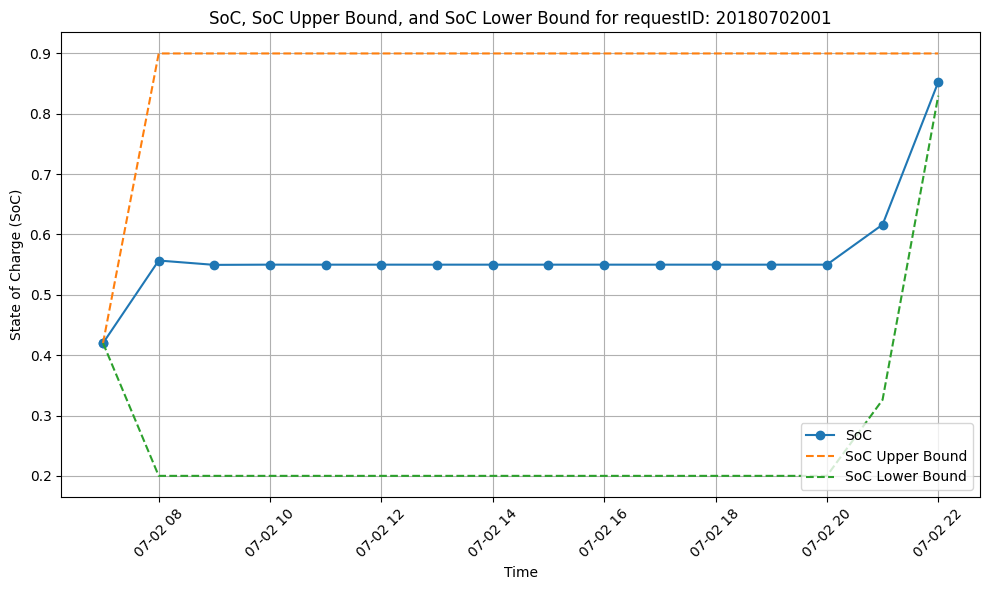

In [2]:
result_dir = './Result/GB-MARL_alpha0.5_beta0.5_num10/10/' # Replace with the desired result directory
start_date = '2018-07-02'
end_date = '2018-07-03'

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')

# Read the CSV file
soc_history_file_path = result_dir + 'soc_history.csv'
data = pd.read_csv(soc_history_file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

plot_soc_for_requestID(20180702001)  # Replace with the desired requestID


## 原始負載與 EV 充放電後的負載變化圖

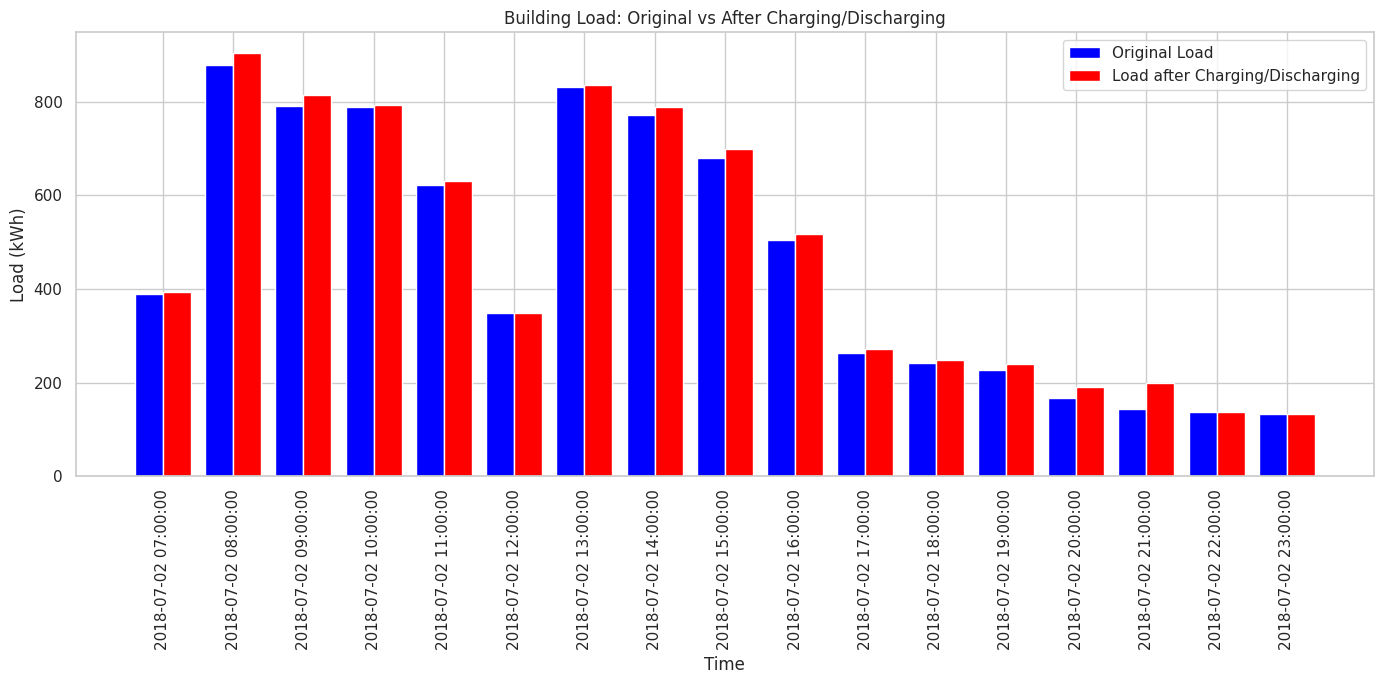

In [41]:
def plot_load_history(file_path, start_date, end_date):
    # Read load history from CSV
    load_history_df = pd.read_csv(file_path, parse_dates=['current_time'])
    
    # Filter data by date range
    mask = (load_history_df['current_time'] >= start_date) & (load_history_df['current_time'] <= end_date)
    filtered_df = load_history_df.loc[mask]
    
    # Plot original load and total load as bar charts
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    bar_positions = range(len(filtered_df))
    
    plt.bar(bar_positions, filtered_df['original_load'], width=bar_width, label='Original Load', color='blue')
    plt.bar([p + bar_width for p in bar_positions], filtered_df['total_load'], width=bar_width, label='Load after Charging/Discharging', color='red')
    
    plt.xlabel('Time')
    plt.ylabel('Load (kWh)')
    plt.title('Building Load: Original vs After Charging/Discharging')
    plt.xticks([p + bar_width/2 for p in bar_positions], filtered_df['current_time'].dt.strftime('%Y-%m-%d %H:%M:%S'), rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
building_load_file_path = result_dir + 'building_loading_history.csv'  # Modify this to the path of your load history file
plot_load_history(building_load_file_path, start_date, end_date)

## 計算建物電力成本

In [42]:
# calculate cost and penalty
def calculate_cost_and_penalty(df, real_time_price, contract_capacity, capacity_price, start_time, end_time):
    # filter data by start and end time
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered = df[(df['current_time'] >= start_time) & (df['current_time'] <= end_time)].copy()
    
    # filter data by hour (7:00 - 23:00)
    df_filtered['hour'] = df_filtered['current_time'].dt.hour
    df_filtered = df_filtered[(df_filtered['hour'] >= 7) & (df_filtered['hour'] <= 23)]
    
    # merge real time price data
    df_filtered = pd.merge(df_filtered, real_time_price, how='left', left_on='current_time', right_on='datetime')

    # calculate cost
    df_filtered['cost'] = df_filtered['total_load'] * df_filtered['average_price']

    # calculate total cost
    current_tariff = df_filtered['cost'].sum()
    total_cost = current_tariff

    # calculate overload penalty
    df_filtered['month'] = df_filtered['current_time'].dt.month
    overload_penalties = []

    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[df_filtered['month'] == month]
        overload_penalty = 0
        overload = monthly_data['total_load'].max()
        
        if overload > contract_capacity:
            overload -= contract_capacity
            overload_penalty += min(overload, contract_capacity * 0.1) * capacity_price * 2  # between 0% and 10% of contract capacity
            overload -= min(overload, contract_capacity * 0.1)
            overload_penalty += overload * capacity_price * 3  # more than 10% of contract capacity
        overload_penalties.append(overload_penalty)

    total_overload_penalty = sum(overload_penalties)
    
    return df_filtered, total_cost, total_overload_penalty, current_tariff

def set_real_time_price_range(real_time_price, start_time: datetime, end_time: datetime):
    real_time_price = real_time_price[(real_time_price['datetime'] >= start_time) & (real_time_price['datetime'] <= end_time)].copy()
    real_time_price.sort_values(by='datetime', inplace=True)
    return real_time_price

In [43]:
# set start and end datetime
start_datetime_str = '2018-09-01'
end_datetime_str = '2018-09-30'

# convert string to datetime
start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d')
end_datetime = datetime.strptime(end_datetime_str, '%Y-%m-%d')


# set contract capacity and capacity price
contract_capacity = 700
capacity_price = 15

# get real time price data
real_time_price = pd.read_csv('./Dataset/RTP/electricity_prices_from_201807010000_to_201812312359.csv')
real_time_price['datetime'] = pd.to_datetime(real_time_price['datetime'])
real_time_price = set_real_time_price_range(real_time_price, start_datetime, end_datetime)

# get building loading history result data
test_building_file = '/test_building_loading_history.csv'
test_soc_file = '/test_soc_history.csv'
test_charging_file = '/test_charging_records.csv'

building_file = '/building_loading_history.csv'
soc_file = '/soc_history.csv'
charging_file = '/charging_records.csv'


DayAhead_dir = './Result/DayAheadSchedule_09-01_09-30_num10/2'
GB_MARL_dir = './Result/GB-MARL-v2_alpha0.5_beta0.1_num10/3'
MADDPG_dir = './Result/MADDPG_07-01_09-01_10/1'
VDN_dir = './Result/VDN-MARL_alpha0.5_beta0.5_num10/1'
IQL_dir = './Result/IQL-MARL_07-01_09-01_10/1'
DDPG_dir = './Result/DDPG_alpha0.5_beta0.5_10/1'
Random_dir = './Result/RandomPower_09-01_09-30_10/2'
Unschedule_dir = './Result/Unschedule_09-01_09-30_10/2'

DayAhead_building_file = DayAhead_dir + building_file
GB_MARL_building_file = GB_MARL_dir + test_building_file
MADDPG_building_file = MADDPG_dir + test_building_file
VDN_building_file = VDN_dir + test_building_file
IQL_building_file = IQL_dir + test_building_file
DDPG_building_file = DDPG_dir + test_building_file
Random_building_file = Random_dir + building_file
Unschedule_building_file = Unschedule_dir + building_file

# set file paths and method names
methods = [DayAhead_building_file, GB_MARL_building_file, MADDPG_building_file, 
           VDN_building_file, IQL_building_file, DDPG_building_file, Random_building_file, 
           Unschedule_building_file]

method_names = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
data_frames = []

# read data
for method in methods:
    df = pd.read_csv(method)
    data_frames.append(df)
    
# calculate cost and penalty for each method
total_costs = []
overload_penalties = []
current_tariffs = []
for df, method_name in zip(data_frames, method_names):
    df_filtered, total_cost, total_overload_penalty, current_tariff = \
        calculate_cost_and_penalty(df, real_time_price, contract_capacity, 
                                    capacity_price, start_datetime, end_datetime)
        
    total_cost += total_overload_penalty  # add overload penalty to total cost
    total_costs.append(total_cost)
    overload_penalties.append(total_overload_penalty)
    current_tariffs.append(current_tariff)

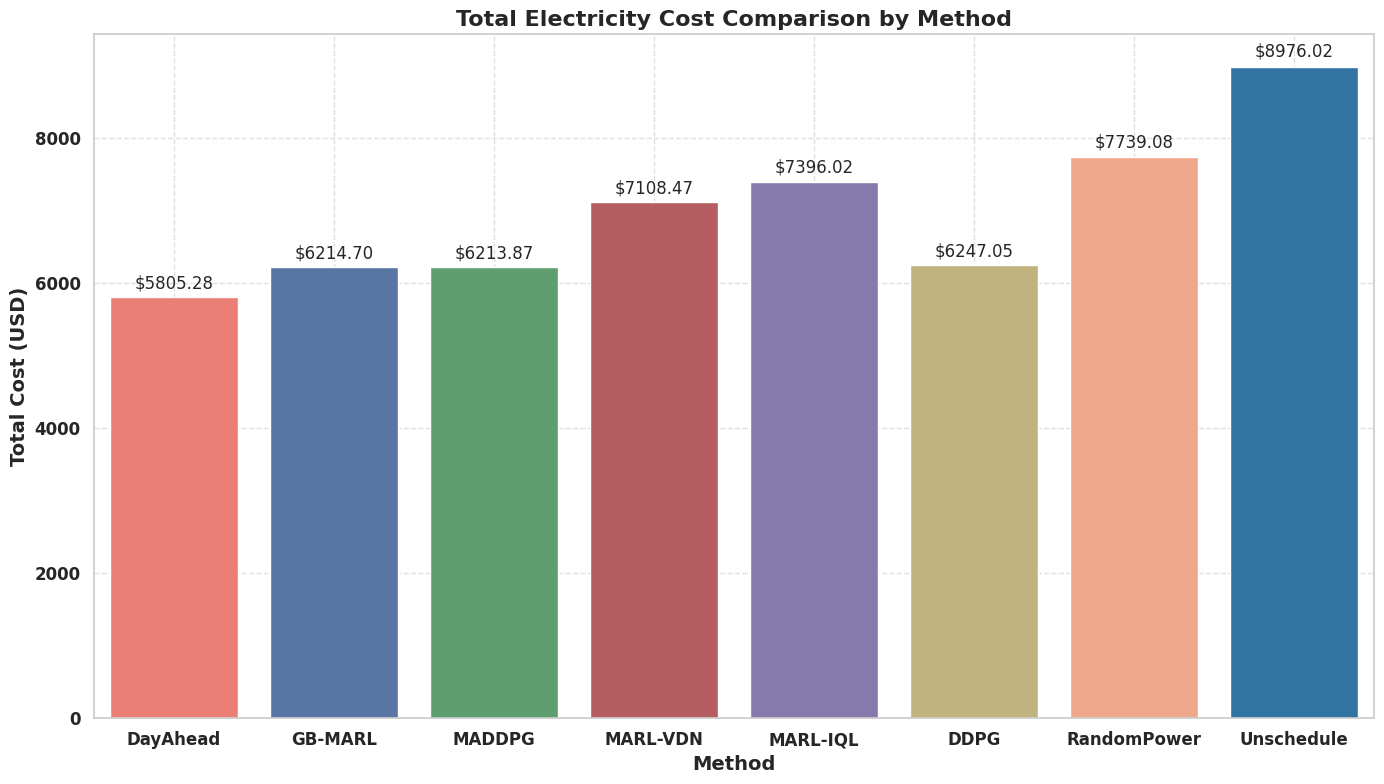

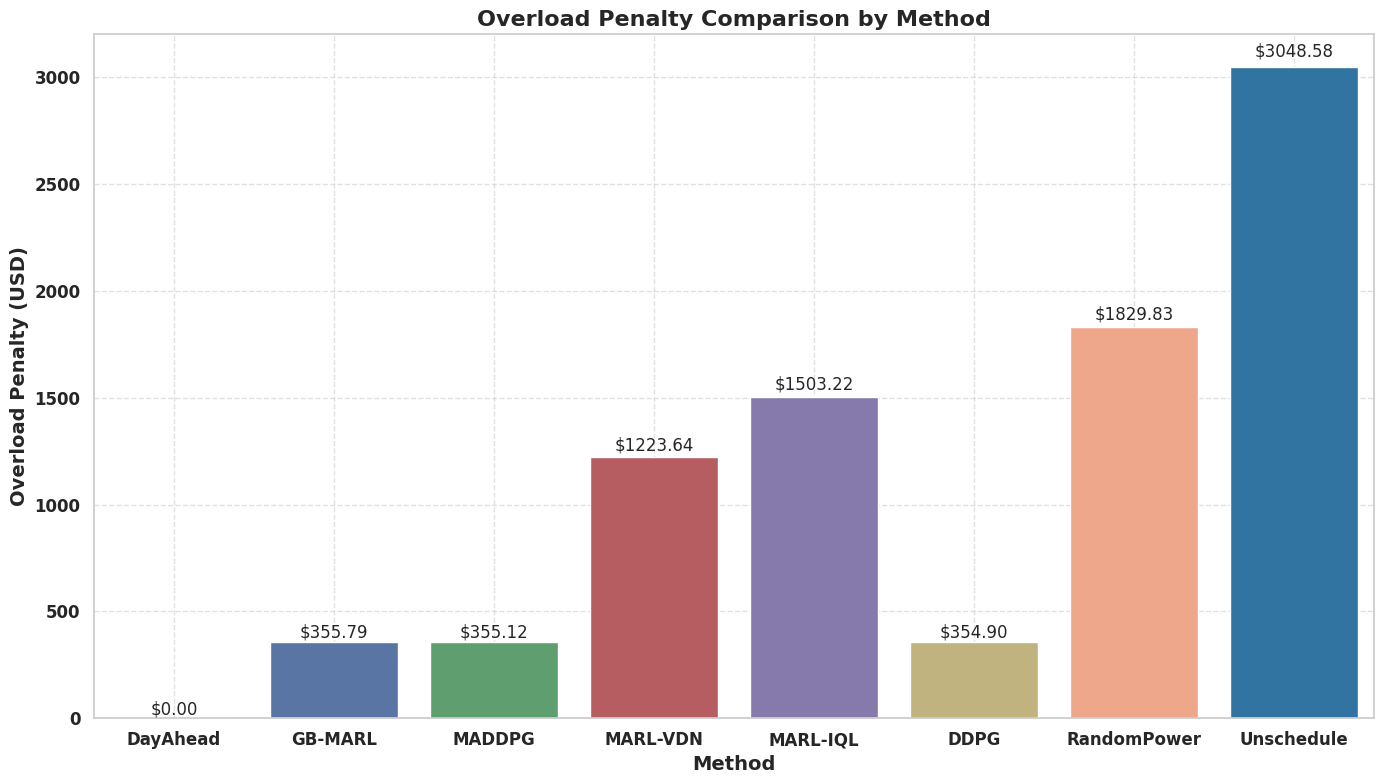

In [33]:
# set plot style
sns.set(style="whitegrid")

# define colors
colors = ['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4']

# plot total cost bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=total_costs, palette=colors, ax=ax)

# add labels and title
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Cost (USD)', fontsize=14, fontweight='bold')
ax.set_title('Total Electricity Cost Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# display total cost on top of each bar
for bar, yval in zip(bars.patches, total_costs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, 
            f'${height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()

# plot overload penalty bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=overload_penalties, palette=colors, ax=ax)

# add labels and title
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Overload Penalty (USD)', fontsize=14, fontweight='bold')
ax.set_title('Overload Penalty Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# display overload penalty on top of each bar
for bar, yval in zip(bars.patches, overload_penalties):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


# fig, ax = plt.subplots(figsize=(14, 8))
# bars = sns.barplot(x=method_names, y=current_tariffs, palette=colors, ax=ax)

# ax.set_xlabel('Method', fontsize=14, fontweight='bold')
# ax.set_ylabel('Current Tariff (USD)', fontsize=14, fontweight='bold')
# ax.set_title('Current Tariff Comparison by Method', fontsize=16, fontweight='bold')
# ax.grid(True, linestyle='--', alpha=0.6)

# for bar, yval in zip(bars.patches, current_tariffs):
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)
    
# plt.xticks(fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')
# plt.tight_layout()

# plt.show()


## 計算波峰波谷比 (pead to valley ratio)

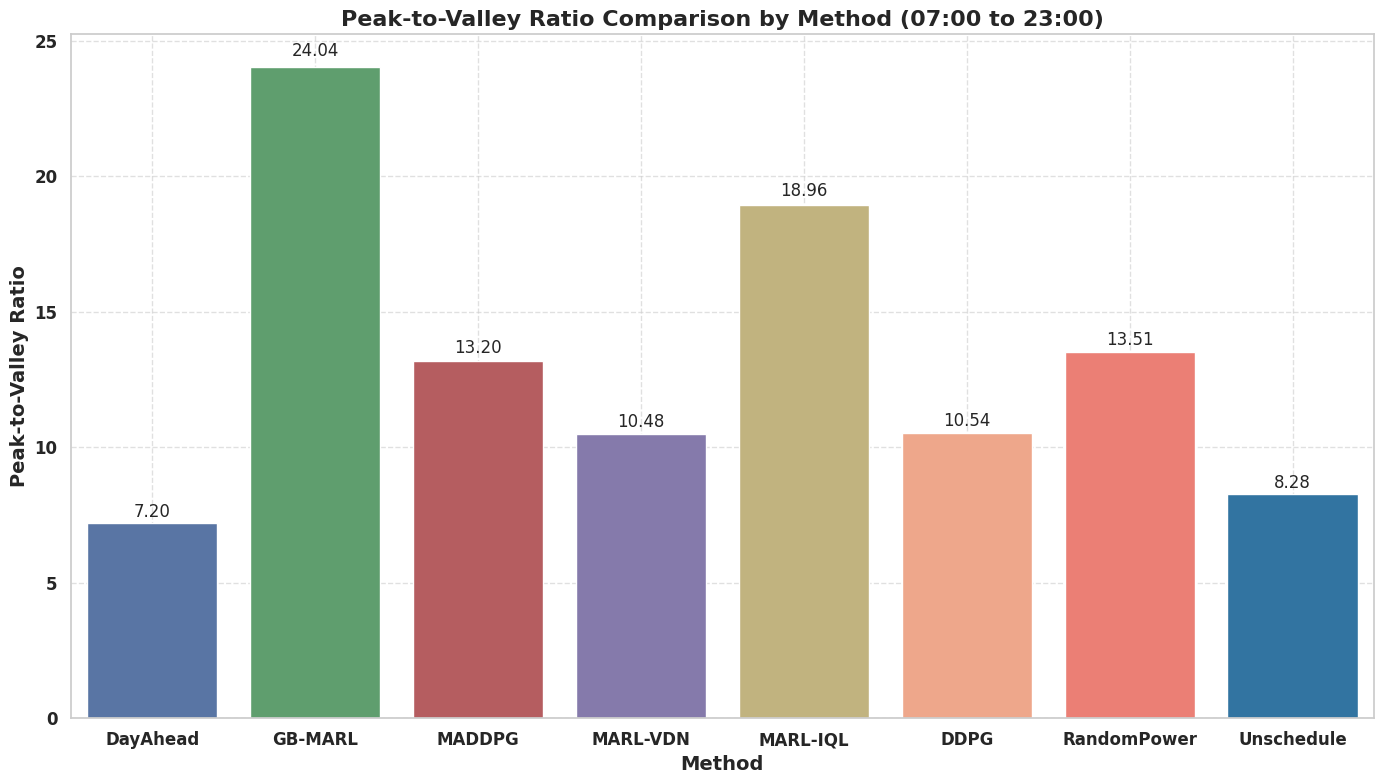

In [26]:
# calculate peak-to-valley ratio
peak_to_valley_ratios = []
for df, method_name in zip(data_frames, method_names):
    # filter data by date range
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered_date = df[(df['current_time'] >= start_datetime) & (df['current_time'] <= end_datetime)].copy()

    # filter data by time range (07:00 - 23:00)
    df_filtered_time = df_filtered_date[(df_filtered_date['current_time'].dt.time >= time(7, 0, 0)) & (df_filtered_date['current_time'].dt.time <= time(23, 0, 0))].copy()

    # calculate peak-to-valley ratio
    peak_load = df_filtered_time['total_load'].max()
    valley_load = df_filtered_time['total_load'].min()
    peak_to_valley_ratio = peak_load / valley_load
    peak_to_valley_ratios.append(peak_to_valley_ratio)
    # print(f'Peak-to-Valley Ratio for {method_name} from {start_datetime_str} to {end_datetime_str} (07:00 to 23:00): {peak_to_valley_ratio:.2f}')

# set plot style
sns.set(style="whitegrid")

# define colors
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#FF6F61', '#1F77B4']

# plot peak-to-valley ratio bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=peak_to_valley_ratios, palette=colors, ax=ax)

# add labels and title
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Peak-to-Valley Ratio', fontsize=14, fontweight='bold')
ax.set_title('Peak-to-Valley Ratio Comparison by Method (07:00 to 23:00)', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# display peak-to-valley ratio on top of each bar
for bar, yval in zip(bars.patches, peak_to_valley_ratios):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()


## EV 離開滿意度 Satisfication

In [48]:
# calculate satisfaction
def calculate_satisfaction(df):
    df['satisfaction'] = df.apply(lambda x: 1 if x['final_soc'] >= x['departure_soc'] else x['final_soc'] / x['departure_soc'], axis=1)
    df['departure_time'] = pd.to_datetime(df['departure_time'])
    return df

# read data
charging_records_file = '/charging_records.csv'
DayAhead_charging_record_file = DayAhead_dir + charging_records_file
GB_MARL_charging_record_file = GB_MARL_dir + test_charging_file
MADDPG_charging_record_file = MADDPG_dir + test_charging_file
VDN_charging_record_file = VDN_dir + test_charging_file
IQL_charging_record_file = IQL_dir + test_charging_file
DDPG_charging_record_file = DDPG_dir + test_charging_file
Random_charging_record_file = Random_dir + charging_records_file
Unschedule_charging_record_file = Unschedule_dir + charging_records_file

methods = [DayAhead_charging_record_file, GB_MARL_charging_record_file, MADDPG_charging_record_file, VDN_charging_record_file, 
           IQL_charging_record_file, DDPG_charging_record_file, Random_charging_record_file, Unschedule_charging_record_file]
method_names = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
data_frames = []

for method in methods:
    df = pd.read_csv(method)
    print(method)
    print(df.head())
    df = calculate_satisfaction(df)
    data_frames.append(df)

./Result/DayAheadSchedule_09-01_09-30_num10/2/charging_records.csv
     requestID         arrival_time       departure_time  initial_soc  \
0  20180901001  2018-09-01 08:00:00  2018-09-01 18:00:00         0.55   
1  20180901002  2018-09-01 11:00:00  2018-09-01 17:00:00         0.53   
2  20180901003  2018-09-01 11:00:00  2018-09-01 21:00:00         0.47   
3  20180901004  2018-09-01 07:00:00  2018-09-01 18:00:00         0.59   
4  20180901005  2018-09-01 09:00:00  2018-09-01 19:00:00         0.36   

   departure_soc  final_soc  charging_power  charging_time  
0           0.62       0.62             4.2             10  
1           0.87       0.87            20.4              6  
2           0.73       0.73            15.6             10  
3           0.75       0.75             9.6             11  
4           0.79       0.79            25.8             10  
./Result/GB-MARL-v2_alpha0.5_beta0.1_num10/3/test_charging_records.csv
     requestID         arrival_time       departure_time 

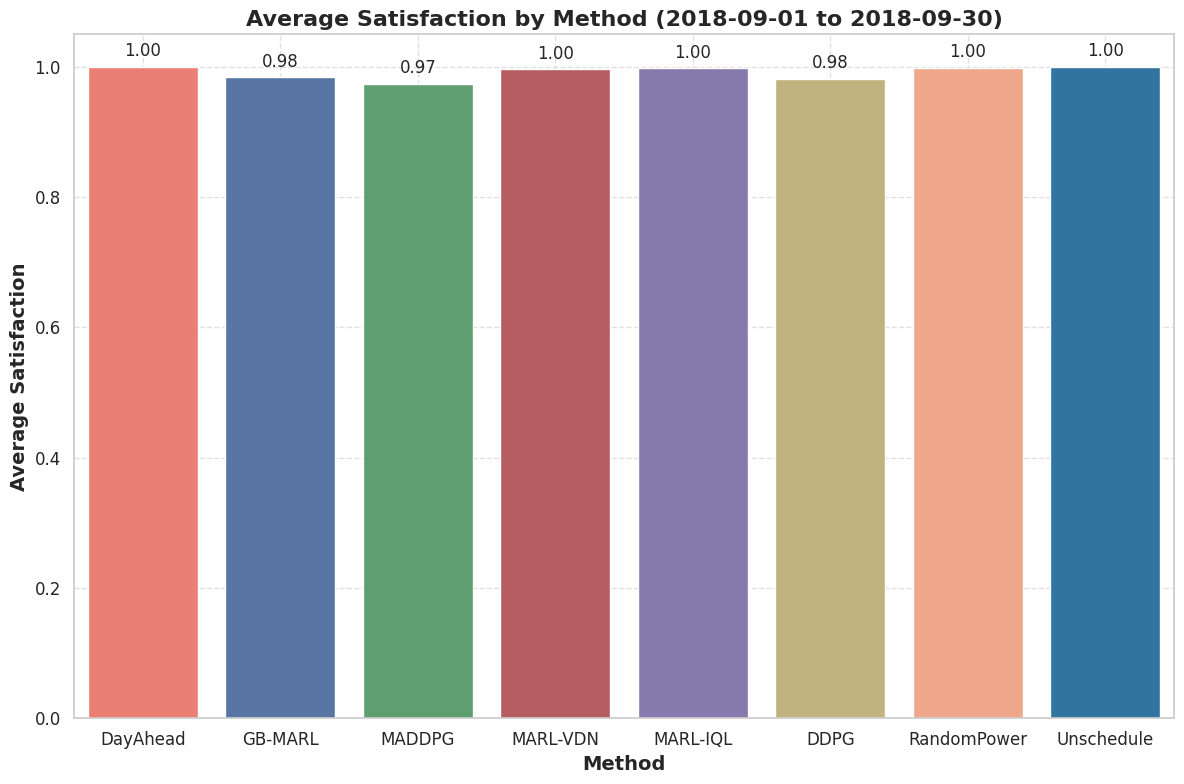

In [49]:
# calculate average satisfaction
avg_satisfaction = []
for df in data_frames:
    df_filtered = df[(df['departure_time'] >= start_datetime) & (df['departure_time'] <= end_datetime)]
    avg_satisfaction.append(df_filtered['satisfaction'].mean())

# set plot style
sns.set(style="whitegrid")

# plot average satisfaction bar chart
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4'])
# add labels and title
plt.xlabel('Method', fontsize=14, fontweight='bold')
plt.ylabel('Average Satisfaction', fontsize=14, fontweight='bold')
plt.title(f'Average Satisfaction by Method ({start_datetime.date()} to {end_datetime.date()})', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# display average satisfaction on top of each bar
for bar, yval in zip(bars.patches, avg_satisfaction):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


In [51]:
# calculate midway satisfaction
def calculate_midway_satisfaction(df, start_date, end_date):
    # calculate midway time for each requestID
    df['current_time'] = pd.to_datetime(df['current_time'])
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2)
    
    # filter midway time by date range
    midway_time = midway_time[(midway_time >= start_date) & (midway_time < end_date)]

    # calculate satisfaction for each requestID
    satisfaction = []
    for requestID, mid_time in midway_time.items():
        mid_time_index = (df['requestID'] == requestID) & (df['current_time'] == mid_time)
        if not mid_time_index.any():
            # find the closest row to the midway time
            closest_index = (df['requestID'] == requestID) & (df['current_time'] >= start_date) & (df['current_time'] < end_date)
            closest_row = df[closest_index].iloc[(df[closest_index]['current_time'] - mid_time).abs().argsort()[:1]]
            midway_soc = closest_row['soc'].values[0]
        else:
            midway_soc = df[mid_time_index]['soc'].values[0]
        satisfaction.append(midway_soc / 0.9)
    
    return pd.Series(satisfaction)

# read data
soc_file = '/soc_history.csv'
DayAhead_soc_file_file = DayAhead_dir + soc_file
GB_MARL_soc_file_file = GB_MARL_dir + test_soc_file
MADDPG_soc_file_file = MADDPG_dir + test_soc_file
VDN_soc_file_file = VDN_dir + test_soc_file
IQL_soc_file_file = IQL_dir + test_soc_file
DDPG_soc_file_file = DDPG_dir + test_soc_file
Random_soc_file_file = Random_dir + soc_file
Unschedule_soc_file_file = Unschedule_dir + soc_file

methods = [DayAhead_soc_file_file, GB_MARL_soc_file_file, MADDPG_soc_file_file, VDN_soc_file_file, 
           IQL_soc_file_file, DDPG_soc_file_file, Random_soc_file_file, Unschedule_soc_file_file]
method_names = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
data_frames = []

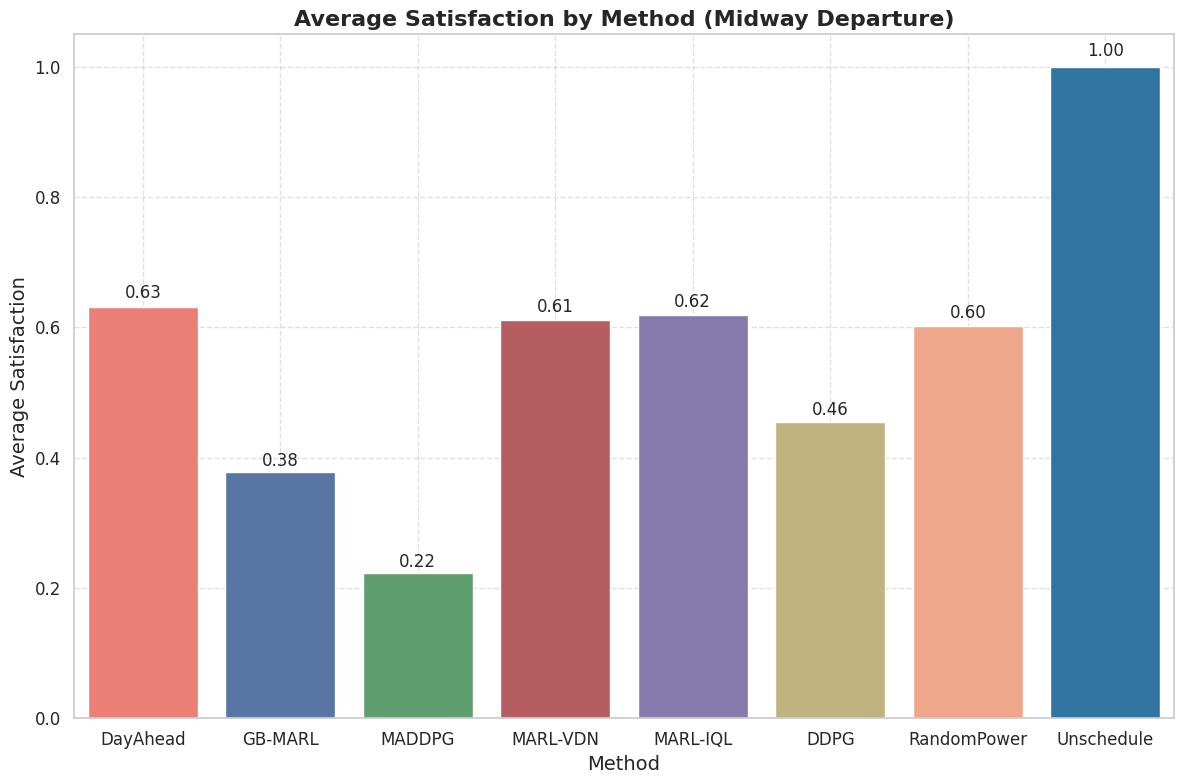

In [52]:
for method in methods:
    df = pd.read_csv(method)
    satisfaction = calculate_midway_satisfaction(df, start_datetime, end_datetime)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

sns.set(style="whitegrid")
# plot average satisfaction bar chart
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4'])

# add labels and title
plt.xlabel('Method', fontsize=14)
plt.ylabel('Average Satisfaction', fontsize=14)
plt.title(f'Average Satisfaction by Method (Midway Departure)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# display average satisfaction on top of each bar
for bar, yval in zip(bars.patches, avg_satisfaction):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()
plt.show()